In [76]:
import random
import time
import os
from collections import Counter
from IPython.display import clear_output

import numpy as np
import torch
from torch import nn, optim, cuda
from torch.optim.lr_scheduler import CosineAnnealingLR
# import torchmetrics
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchmetrics import JaccardIndex, Dice
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
import segmentation_models_pytorch as smp
from PIL import Image


BS = 45
RESIZE = (256, 256)

Check for CUDA available

In [77]:
device = 'cpu'
if cuda.is_available():
    device_name = cuda.get_device_name(0)
    memory = cuda.get_device_properties(0).total_memory / (1024 ** 3)
    print(f"Device {device_name} has {memory} GB of memory")
    device = torch.device('cuda')
else:
    raise Exception("Cuda isn't available")
device

Device NVIDIA GeForce RTX 3060 Ti has 7.9993896484375 GB of memory


device(type='cuda')

Transform ad augment dataset

In [78]:
val_transform = transforms.Compose([
    transforms.Resize(RESIZE),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(dtype=torch.float32),
])

train_transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=180),
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    # transforms.RandomPerspective(distortion_scale=0.2, p=0.5),

    transforms.Resize(RESIZE),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(dtype=torch.float32)
])

color_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.3, contrast=0.4, saturation=0.5, hue=0.1),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

normalize_transform = transforms.Compose([
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


class SegmentationDataset(Dataset):
    def __init__(self, root, uniform_transform, color_transform=None):
        self.image_dir = os.path.join(root, 'images')
        self.mask_dir = os.path.join(root, 'labels')
        self.images = os.listdir(self.image_dir)

        self.uniform_transform = uniform_transform
        self.color_transform = color_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        seed = np.random.randint(2147483647)

        random.seed(seed)
        torch.manual_seed(seed)
        np.random.seed(seed)
        image = self.uniform_transform(image)

        random.seed(seed)
        torch.manual_seed(seed)
        np.random.seed(seed)
        mask = self.uniform_transform(mask)

        if self.color_transform:
            image = self.color_transform(image)

        mask = (mask > 0).float()  # Ensure mask is binary (0 or 1)

        return image, mask

train_dataset = SegmentationDataset('./dataset/train', train_transform, color_transform)
val_dataset = SegmentationDataset('./dataset/val', val_transform)
test_dataset = SegmentationDataset('./dataset/test', val_transform)

train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False)

original_train_dataset = SegmentationDataset('./dataset/train', val_transform)
original_train_loader = DataLoader(original_train_dataset, batch_size=BS, shuffle=False)

augmented_train_dataset = SegmentationDataset('./dataset/train', train_transform, color_transform)
augmented_train_loader = DataLoader(augmented_train_dataset, batch_size=BS, shuffle=False)

Check dataset stat

In [79]:
train_count = len(train_dataset)
val_count = len(val_dataset)
test_count = len(test_dataset)

print("Train Dataset Image Count:")
print(train_count)

print("Val Dataset Image Count:")
print(val_count)

print("Test Dataset Image Count:")
print(test_count)

Train Dataset Image Count:
45
Val Dataset Image Count:
4
Test Dataset Image Count:
3


Compare original and augmented images

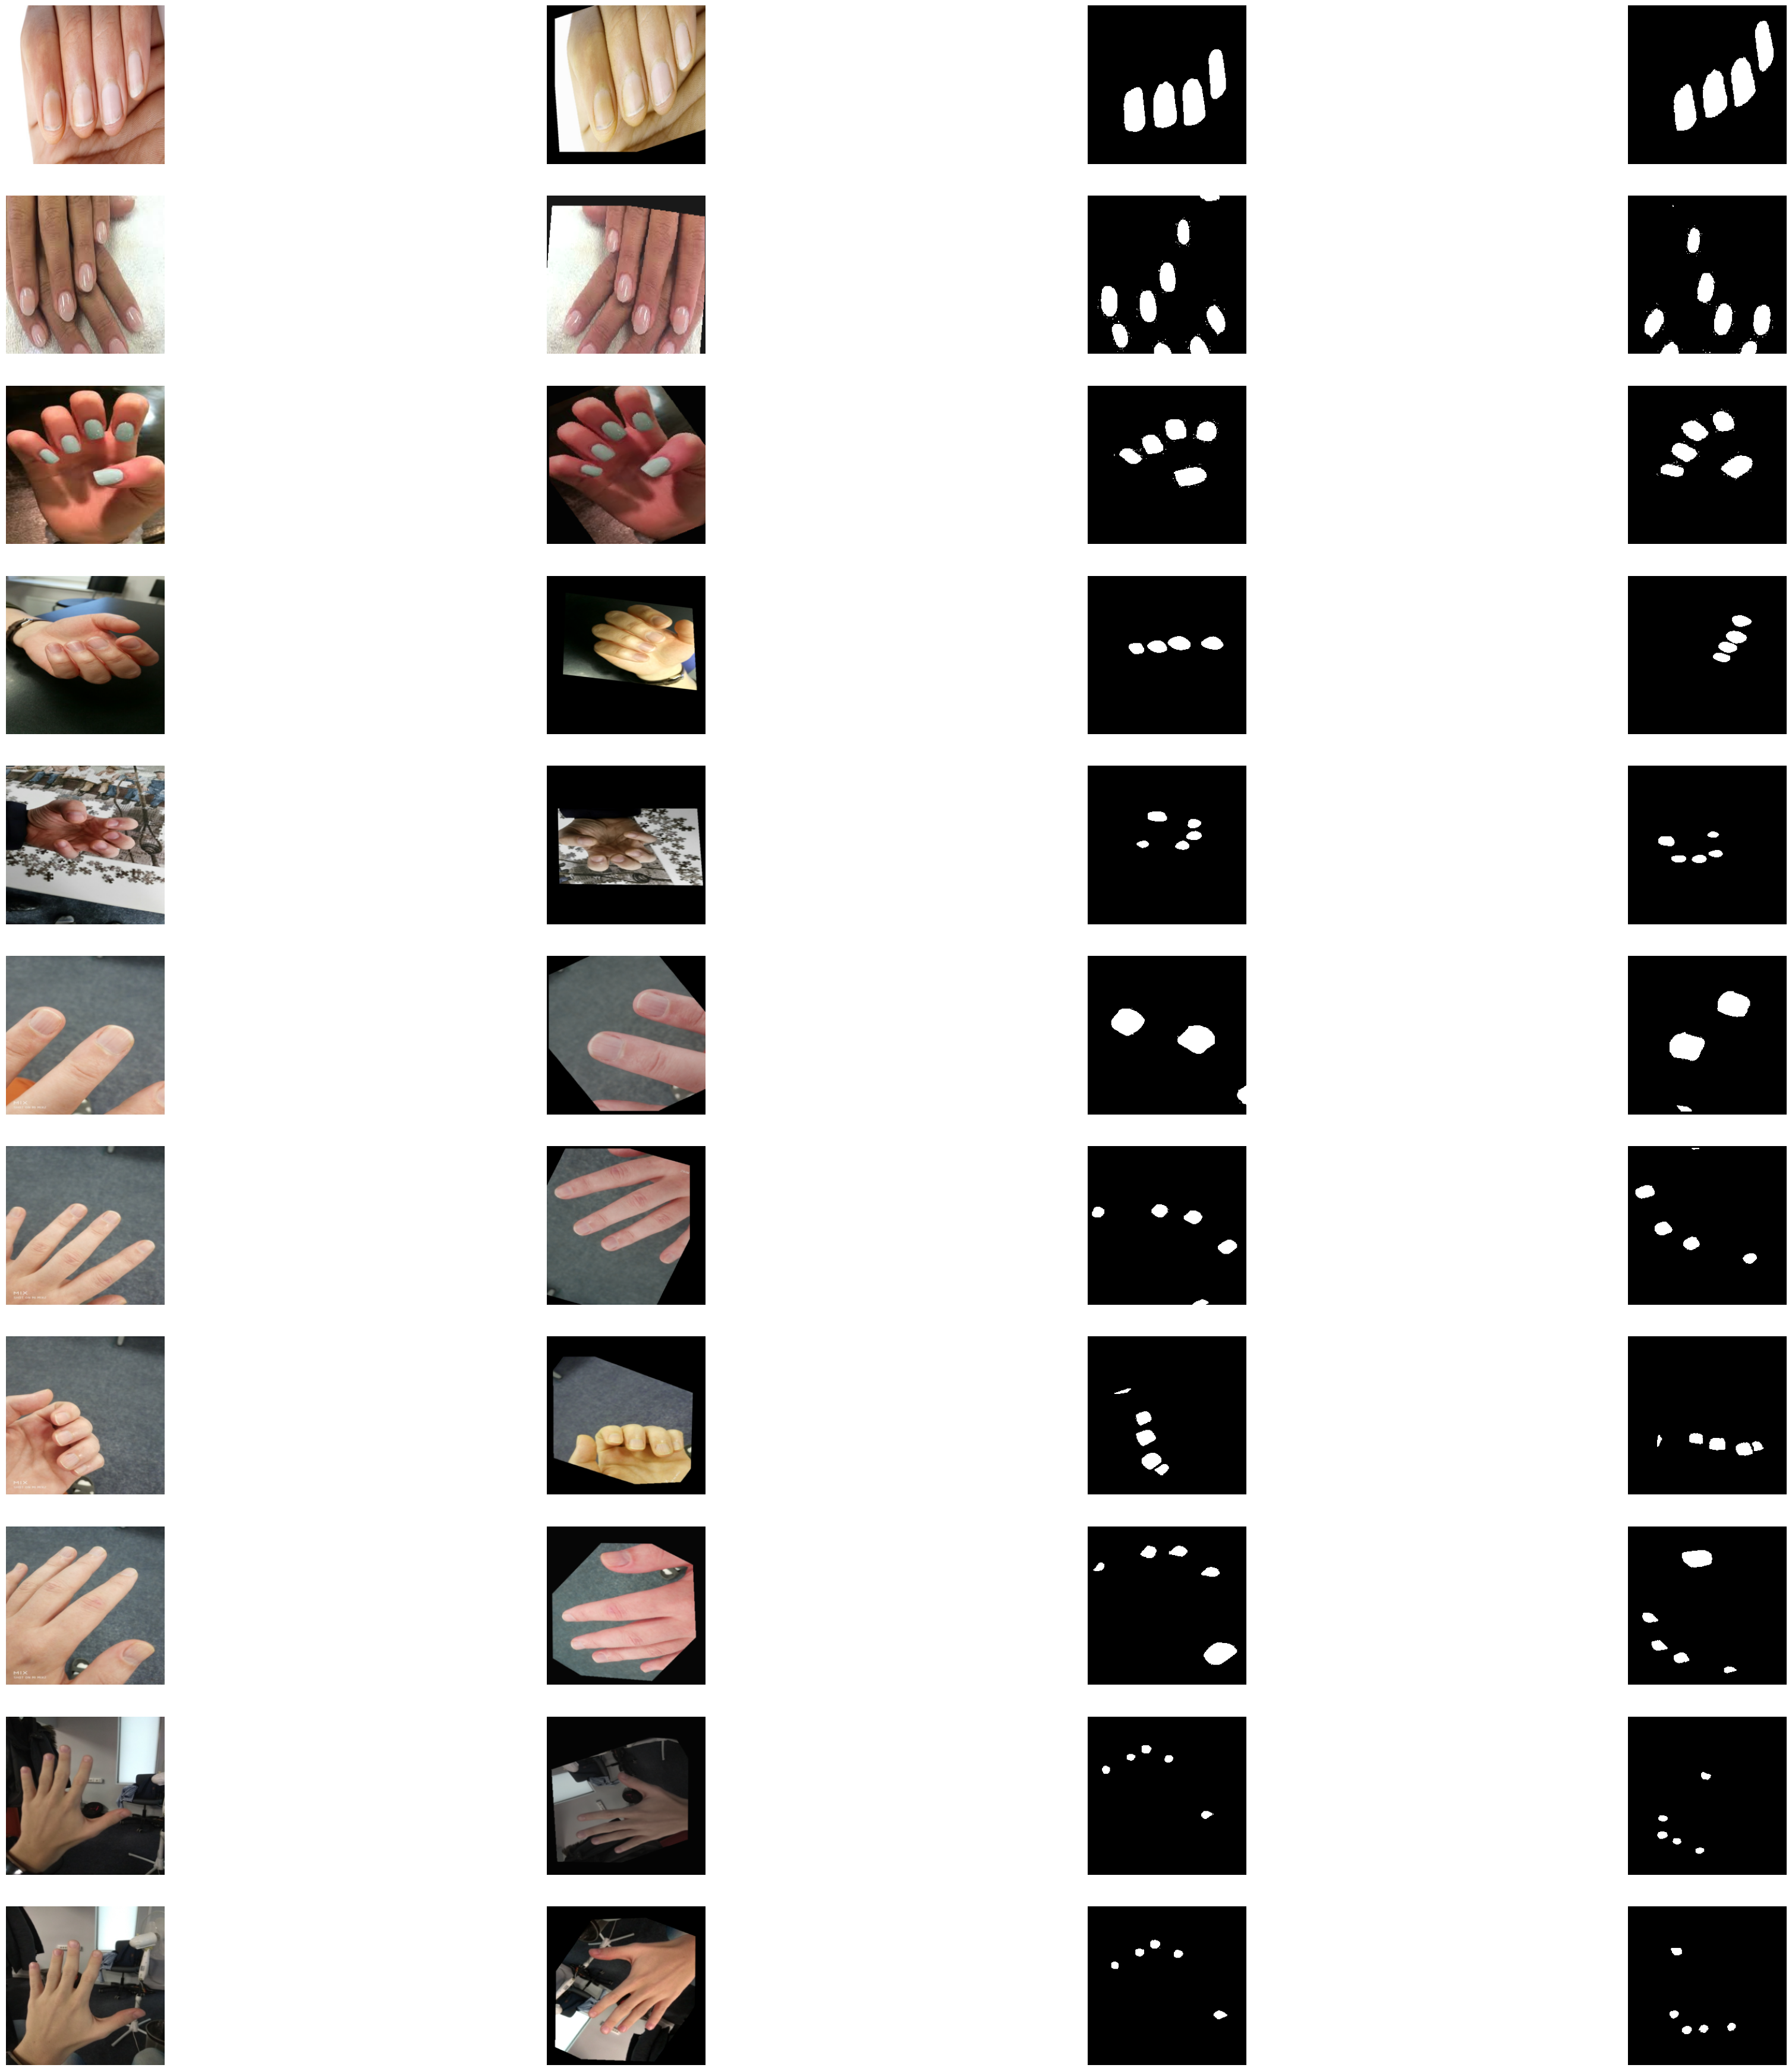

In [80]:
def show_original_and_augmented(original_images, augmented_images, original_masks, augmented_masks):
    fig, axes = plt.subplots(BS, 4, figsize=(BS, BS * 4))
    for i in range(0, BS, 1):
        axes[i, 0].imshow(original_images[i].permute(1, 2, 0))
        axes[i, 0].axis('off')

        axes[i, 1].imshow(augmented_images[i].permute(1, 2, 0))
        axes[i, 1].axis('off')

        axes[i, 2].imshow(original_masks[i].squeeze(), cmap='gray')
        axes[i, 2].axis('off')

        axes[i, 3].imshow(augmented_masks[i].squeeze(), cmap='gray')
        axes[i, 3].axis('off')
    plt.show()

original_images, original_masks = next(iter(original_train_loader))
augmented_images, augmented_masks = next(iter(augmented_train_loader))

show_original_and_augmented(original_images, augmented_images, original_masks, augmented_masks)

Delete model to avoid errors with pretrained

In [81]:
try:
  if model:
    model.zero_grad()
    del model
    torch.cuda.empty_cache()
    print('model has been deleted')
except:
  print('model doesnt exist')

model has been deleted


Init model

In [82]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)

model.to(device)
# model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

Define hyperparameters

In [83]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 100
# lr_scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

len_loader = len(train_loader)

Make and manage runs dir

In [84]:
runs_dir = "runs"
os.makedirs(runs_dir, exist_ok=True)
existing_runs = [d for d in os.listdir(runs_dir) if os.path.isdir(os.path.join(runs_dir, d))]


if existing_runs:
    max_index = max([int(d.split("run")[1]) for d in existing_runs])
    new_run_index = max_index + 1
else:
    new_run_index = 1

current_run_dir = os.path.join(runs_dir, f"run{new_run_index}")
os.makedirs(current_run_dir, exist_ok=True)

train_stats_file = os.path.join(current_run_dir, "train_stats.csv")
test_stats_file = os.path.join(current_run_dir, "test_stats.txt")
best_model_weights_file = os.path.join(current_run_dir, "best.pth")
plot_file = os.path.join(current_run_dir, "plot.png")

with open(train_stats_file, 'w') as f:
    f.write(f"Epocht\tTrain Loss\tVal Loss\tVal Accuracy\tDur\tDur/Epoch\n")

Show loss plot, metrics plot and last epoch stats

In [85]:
def show_stats(x_vals, train_losses, val_losses, IoU_list, DICE_list):
    clear_output(wait=True)

    if not x_vals:
        return

    #fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    ax1.plot(x_vals, train_losses, label='Train Loss')
    ax1.plot(x_vals, val_losses, label='Val Loss')
    ax1.legend()
    ax1.grid(True)
    ax1.set_xticks(x_vals[::5])
    ax1.set_xticklabels(x_vals[::5], rotation=90)
    ax1.set_title('Loss')

    # Второй график
    ax2.plot(x_vals, IoU_list, label='IoU')
    ax2.plot(x_vals, DICE_list, label='DICE')
    ax2.legend()
    ax2.grid(True)
    ax1.set_xticks(x_vals[::5])
    ax2.set_xticklabels(x_vals[::5], rotation=90)
    ax2.set_title('Metrics')

    plt.tight_layout()
    plt.show()
    plt.savefig(plot_file)

    print(train_losses)
    print(val_losses)
    print(f"IoU: {IoU_list[-1]}")
    print(f"DICE: {DICE_list[-1]}")

In [86]:
def calculate_metrics(predicted, labels):
    div_epsilon = 1e-10

    predicted = predicted.view(-1)
    labels = labels.view(-1)

    TP = (predicted * labels).sum().item()
    FP = ((1 - labels) * predicted).sum().item()
    FN = (labels * (1 - predicted)).sum().item()
    TN = ((1 - labels) * (1 - predicted)).sum().item()

    iou = TP / (TP + FP + FN + div_epsilon)
    dice = (2 * TP) / (2 * TP + FP + FN + div_epsilon)

    return iou, dice

Train loop

C:\Users\kuzga\AppData\Local\Temp\ipykernel_6824\3201575466.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(x_vals[::5], rotation=90)


<Figure size 640x480 with 0 Axes>

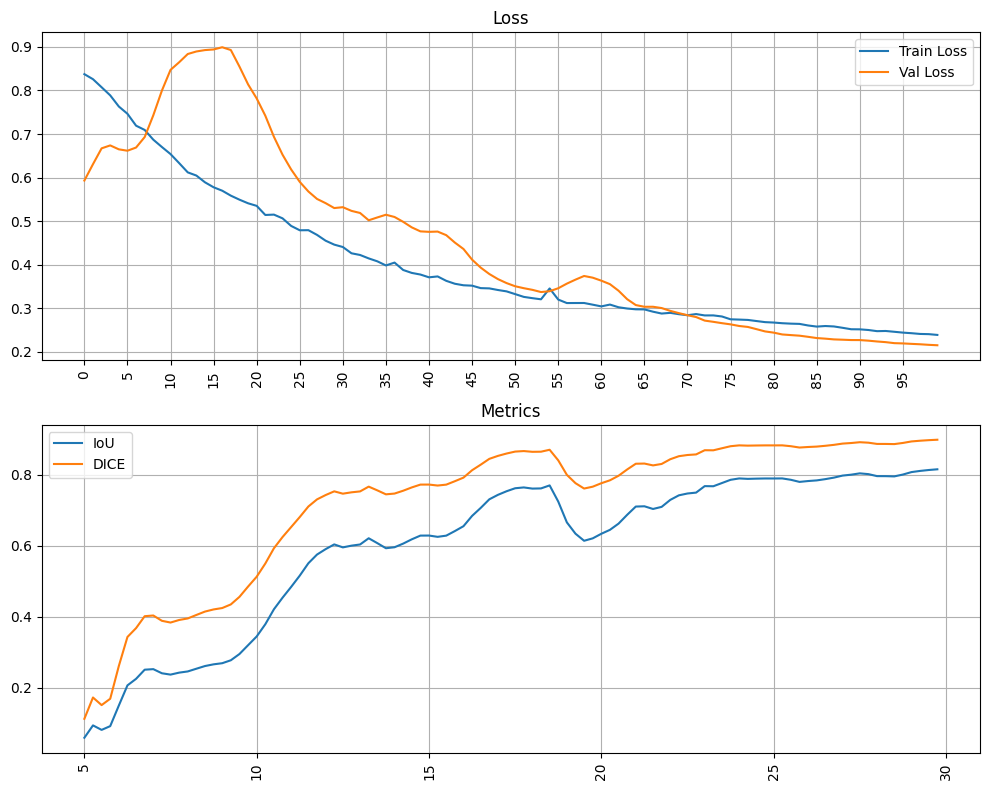

[0.8374641537666321, 0.8259146809577942, 0.8074169754981995, 0.7887926697731018, 0.763202965259552, 0.7465264201164246, 0.7192026972770691, 0.7094142436981201, 0.6870752573013306, 0.6702096462249756, 0.6540161371231079, 0.6332886219024658, 0.6120193600654602, 0.6047009825706482, 0.5891814231872559, 0.5777945518493652, 0.5699403882026672, 0.5585631728172302, 0.5493571162223816, 0.5410600304603577, 0.5351213216781616, 0.5142340660095215, 0.5150495767593384, 0.5064865946769714, 0.4890897274017334, 0.4791034460067749, 0.47931909561157227, 0.46853503584861755, 0.4551747739315033, 0.44616225361824036, 0.4406857192516327, 0.42628955841064453, 0.4224010109901428, 0.41454052925109863, 0.4078264832496643, 0.39836108684539795, 0.40492403507232666, 0.38793981075286865, 0.38121533393859863, 0.37749335169792175, 0.37109512090682983, 0.3731484115123749, 0.3630479574203491, 0.35634058713912964, 0.3528432250022888, 0.3519623279571533, 0.3463076949119568, 0.34569695591926575, 0.3419858515262604, 0.33884

<Figure size 640x480 with 0 Axes>

In [87]:
x_vals = []
train_losses = []
val_losses = []

IoU_list = []
DICE_list = []

best_val_loss = float('inf')
best_val_IoU = 0.0
best_val_DICE = 0.0
best_epoch = 0

div_epsilon = 1e-10

def calculate_metrics(predicted, labels):
    predicted = predicted.view(-1)
    labels = labels.view(-1)

    TP = (predicted * labels).sum().item()
    FP = ((1 - labels) * predicted).sum().item()
    FN = (labels * (1 - predicted)).sum().item()
    TN = ((1 - labels) * (1 - predicted)).sum().item()

    iou = TP / (TP + FP + FN + div_epsilon)
    dice = (2 * TP) / (2 * TP + FP + FN + div_epsilon)

    return iou, dice

start = time.time()
for epoch in range(num_epochs):
    print(f'\rEpoch: {epoch} / {num_epochs}')
    epoch_start = time.time()
    model.train()
    running_loss = 0.0
    val_running_loss = 0.0

    for batch_idx, (images, labels) in enumerate(train_loader):
        print(f"\r Train batch {batch_idx}/{len(train_loader)}", end='', flush=True)

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_train_loss = running_loss / len(train_loader)
    x_vals.append(epoch)
    train_losses.append(epoch_train_loss)
    print('\n')

    model.eval()

    val_IoU = 0.0
    val_DICE = 0.0
    num_batches = 0

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(val_loader):
            print(f"\r Val batch {batch_idx}/{len(val_loader)}", end='', flush=True)

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            predicted = (outputs > 0.5).float()

            iou, dice = calculate_metrics(predicted, labels)
            val_IoU += iou
            val_DICE += dice
            num_batches += 1

        epoch_val_loss = val_running_loss / len(val_loader)
        avg_val_IoU = val_IoU / num_batches
        avg_val_DICE = val_DICE / num_batches

    val_losses.append(epoch_val_loss)
    IoU_list.append(avg_val_IoU)
    DICE_list.append(avg_val_DICE)

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_val_IoU = avg_val_IoU
        best_val_DICE = avg_val_DICE
        best_epoch = epoch
        torch.save(model.state_dict(), best_model_weights_file)
        dur = time.time() - start
        with open(train_stats_file, "a") as f:
            f.write(f"{epoch + 1}\t{num_epochs}\t{epoch_train_loss}\t{epoch_val_loss}\t{avg_val_IoU}\t{avg_val_DICE}\t{dur}\t{dur / epoch if epoch != 0 else 0}\n")
    elif epoch > best_epoch + (num_epochs // 2):
        print(f"\nTraining has stopped at {epoch} / {num_epochs} cuz val loss didn't decrease for {num_epochs // 2} epochs")
        break

    show_stats(x_vals, train_losses, val_losses, IoU_list, DICE_list)


#31 runs:


In [88]:
# torch.save(model.state_dict(), os.path.join(current_run_dir, "last.pth"))
# exit()
# model = models.resnet34()
# num_features = model.fc.in_features
# model.fc = nn.Sequential(
#     nn.Linear(num_features, 1),
#     nn.Sigmoid()
# )
best_model_weights_file = r'C:\Users\kuzga\OneDrive\Рабочий стол\sem4\hotdog_nothotdog\runs\run38\best.pth'
# model.load_state_dict(torch.load(best_model_weights_file))
# model = model.to(device)


TP = 0
FP = 0
TN = 0
FN = 0


model.eval()
running_loss = 0.0

with torch.no_grad():
  for batch_idx, (images, labels) in enumerate(test_loader):
    print(f"\rBatch {batch_idx}/{len(test_loader)}", end='', flush=True)
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    loss = criterion(outputs, labels)
    running_loss += loss.item()

    predicted = torch.argmax(outputs, dim=1)


    TP += ((predicted == 1) & (labels == 1)).sum().item()
    FP += ((predicted == 1) & (labels == 0)).sum().item()
    TN += ((predicted == 0) & (labels == 0)).sum().item()
    FN += ((predicted == 0) & (labels == 1)).sum().item()

    test_acc = (TP + TN) / (TP + FP + TN + FN)
    test_pres = TP / (TP + FP) if (TP + FP) > 0 else 0
    test_rec = TP / (TP + FN) if (TP + FN) > 0 else 0
    test_f1 = 2 * (my_precision * my_recall) / (my_precision + my_recall) if (my_precision + my_recall) > 0 else 0

  test_loss = running_loss / len(test_dataset)

print()
res_str = f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Test Precision: {test_pres:.4f}, Test Recall: {test_rec:.4f}, Test F1-score: {test_f1:.4f}"
print(res_str)
with open(test_stats_file, "a") as f:
  f.write(res_str)

Batch 0/1

NameError: name 'my_precision' is not defined

In [ ]:
#10 epochs: Test Loss: 0.2050, Test Accuracy: 0.9193, Test Precision: 0.5031, Test Recall: 0.4503, Test F1-score: 0.4696
#50 epochs: Test Loss: 0.2354, Test Accuracy: 0.9022, Test Precision: 0.5031, Test Recall: 0.4379, Test F1-score: 0.4616